# **PCA on Extended Yale Face Dataset (Step-by-Step)**

**Step 0** : Import required library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler

Once Google Drive is mounted, you should be able to access your 'ExtendedYale' folder at `/content/drive/MyDrive/ExtendedYale`.

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Step 1: Verify Folder Path**

In [3]:
# check whether drive is mounted or not
!ls /content/drive/MyDrive/ExtendedYaleB/

cropped


# **Step 2: Set Correct Dataset Path (IMPORTANT)**

In [4]:
DATASET_PATH = "/content/drive/MyDrive/ExtendedYaleB/cropped"

# **Step 3: Load .pgm Images from Drive**

In [74]:
# Limit to a subset for memory efficiency
images = []
labels = []
max_images = 1000  # Change this number as needed
count = 0
for subject in sorted(os.listdir(DATASET_PATH)):
    subject_path = os.path.join(DATASET_PATH, subject)

    if not os.path.isdir(subject_path):
        continue

    for file in sorted(os.listdir(subject_path)):
        if file.endswith(".pgm"):
            img_path = os.path.join(subject_path, file)

            img = Image.open(img_path)        # PGM supported
            img = np.array(img, dtype=np.float32)

            images.append(img.flatten())
            labels.append(subject)

            count += 1
            if count >= max_images:
                break
    if count >= max_images:
        break
X = np.array(images)
labels = np.array(labels)

print("Dataset loaded!")
print("X shape:", X.shape)
print("Number of subjects:", len(np.unique(labels)))

Dataset loaded!
X shape: (1000, 32256)
Number of subjects: 2


- 28 subjects × 585 images = **16,380 images**
- Each image ≈ 192 × 168 = **32,256 dimensions**

# **Step 4: Display Sample Faces**

width x height: 192 168


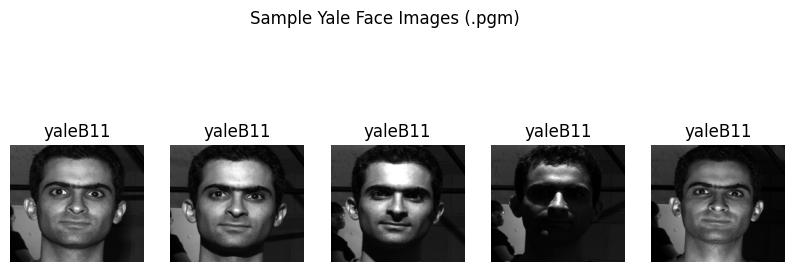

In [75]:
h, w = img.shape
print("width x height:", w, h)

# size of the display window will be 10 x 4 inches
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i].reshape(h, w), cmap="gray")
    plt.title(labels[i])
    plt.axis("off")

plt.suptitle("Sample Yale Face Images (.pgm)")
plt.show()


# **Step 5: Centering the Dataset**

In [76]:
# calculate mean of the data
mean_face = np.mean(X, axis=0)

#subtsrct mean from the data to bring it to the center
X_centered = X - mean_face

##### Visualize mean face

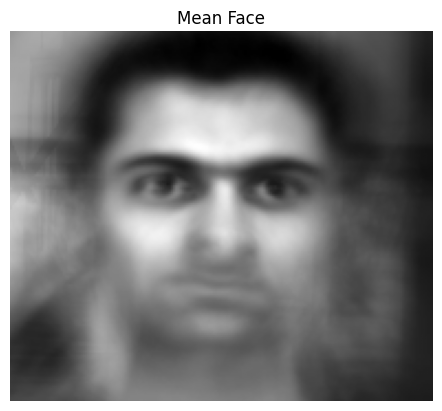

In [101]:
plt.imshow(mean_face.reshape(h, w), cmap="gray")
plt.title("Mean Face")
plt.axis("off")
plt.show()

# **Step 6: Covariance Matrix**

**Covariance Matrix Trick**

The covariance matrix is normally defined as:

$$
C = \frac{1}{N-1} X^T X
$$

**Important Note:**  

Direct computation of $X^T X$ for large data would give a $32k \times 32k$ matrix → impossible to handle in memory.  

So we use a trick: instead of computing $X^T X$ (size $D \times D$), we compute:

$$
X X^T \quad (N \times N)
$$

which is much smaller if $N \ll D$.


In [102]:
cov_matrix = np.dot(X_centered, X_centered.T) / (X_centered.shape[0] - 1)
print("Covariance matrix shape:", cov_matrix.shape)

Covariance matrix shape: (1000, 1000)


# **Step 7: Eigenvalues & Eigenvectors**

In [103]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [108]:
# Sort descending
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

#eigenvalues, eigenvectors

# **Step 8: Compute Eigenfaces (Actual Principal Components)**

**Formula:**

$$
U = X^T V
$$

- Here:
  - $X$ = data matrix (mean-centered images)
  - $V$ = eigenvectors of $X X^T$ (the smaller covariance trick)
  - $U$ = actual eigenfaces (principal components)


In [81]:
eigenfaces = np.dot(X_centered.T, eigenvectors)
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# **Step 9: Visualize Eigenfaces**

These are directions of maximum variance, not real faces.

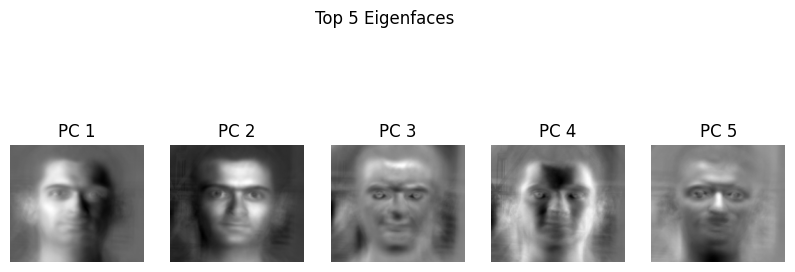

In [82]:
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(eigenfaces[:, i].reshape(h, w), cmap="gray")
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.suptitle("Top 5 Eigenfaces")
plt.show()

# **Step 10: Choosing K (How Many PCs?)**

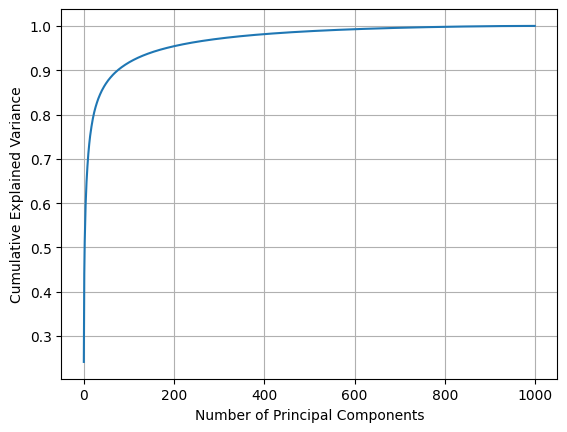

In [83]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

# plot
plt.plot(cumulative_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

#🧠 What this verifies
#PCA is correctly computed
#Increasing PCs → more variance captured
#This should look very similar to your manual PCA plot

In [84]:
K = np.argmax(cumulative_variance >= 0.95) + 1
print("K for 95% variance:", K)

K for 95% variance: 184


# **Step *11*: Project Data onto K PCs**

In [85]:
W = eigenfaces[:, :K]
X_pca = np.dot(X_centered, W)


# **Step 12: Reconstruct Faces Using PCA**

In [86]:
X_reconstructed = np.dot(X_pca, W.T) + mean_face

# **Step 13: Show Reconstruction Quality**

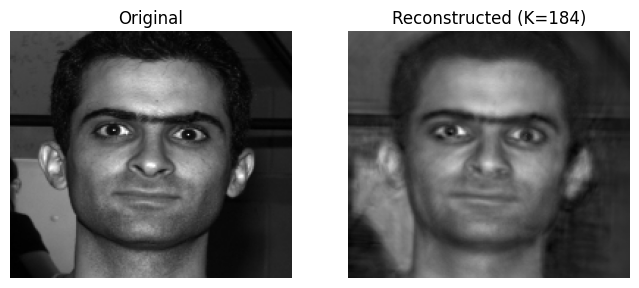

In [87]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(X[0].reshape(h, w), cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(X_reconstructed[0].reshape(h, w), cmap="gray")
plt.title(f"Reconstructed (K={K})")
plt.axis("off")

plt.show()

# PCA compresses → decompresses
# Some information is lost
# More K → better reconstruction

### **Optional: Verify with sklearn PCA**

In [88]:
# ✅ 1. First: PCA claa from sklearn library
from sklearn.decomposition import PCA

pca = PCA(n_components=K)
X_pca_sklearn = pca.fit_transform(X)

print(X_pca_sklearn.shape)

# Before PCA: X.shape = (16380, 32256)
# After PCA: X_pca_sklearn.shape = (16380, K)
# 👉 Dimensionality reduced successfully

(1000, 184)


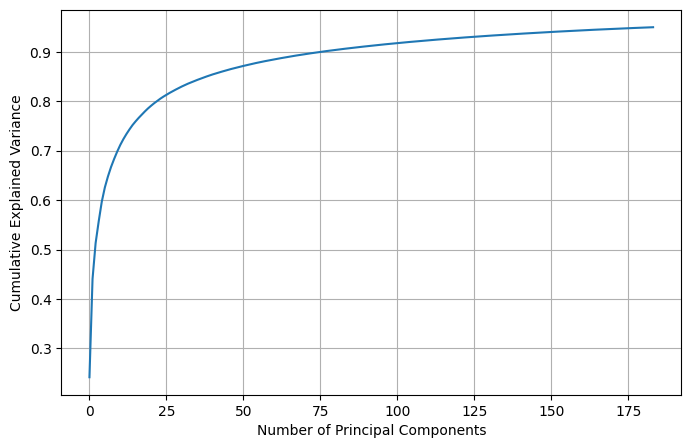

In [89]:
# ✅ 2. Plot Explained Variance (MOST IMPORTANT VERIFICATION)
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

#🧠 What this verifies
#PCA is correctly computed
#Increasing PCs → more variance captured
#This should look very similar to your manual PCA plot

In [90]:
pca.components_

array([[ 4.7999996e-04,  4.1323103e-04,  3.4093909e-04, ...,
         8.3231711e-04,  8.2400197e-04,  8.4098493e-04],
       [ 6.3458376e-04,  6.8451592e-04,  6.1543792e-04, ...,
         1.1869436e-03,  1.1923613e-03,  1.2159747e-03],
       [-7.0211326e-04, -5.3828798e-04, -1.8942993e-04, ...,
         7.1873935e-04,  6.7959400e-04,  6.9378578e-04],
       ...,
       [ 8.3017536e-03,  8.4945243e-03,  8.7363217e-03, ...,
        -1.5488861e-03, -7.9862511e-04, -1.5468203e-04],
       [ 2.5215179e-03,  2.1363341e-03,  2.9366533e-04, ...,
        -9.6437952e-04, -9.3313935e-04, -2.3798503e-04],
       [ 8.6333876e-06, -2.3902445e-03, -4.1004843e-03, ...,
        -3.1223292e-03, -2.7995119e-03, -3.2814101e-03]], dtype=float32)

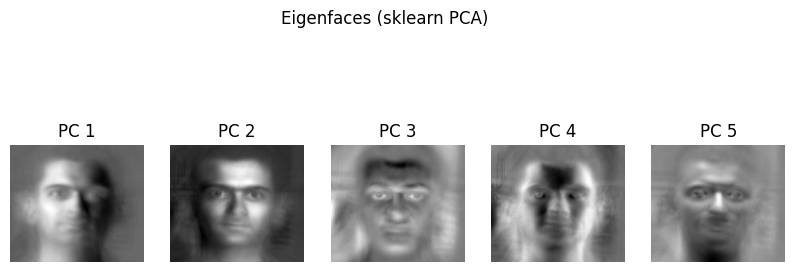

In [91]:
# ✅ 3. Visualize mean face
plt.figure(figsize=(10,4))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pca.components_[i].reshape(h, w), cmap="gray")
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.suptitle("Eigenfaces (sklearn PCA)")
plt.show()

In [92]:
# ✅ 4.Reconstruct Image Using sklearn PCA
X_reconstructed_sklearn = pca.inverse_transform(X_pca_sklearn)

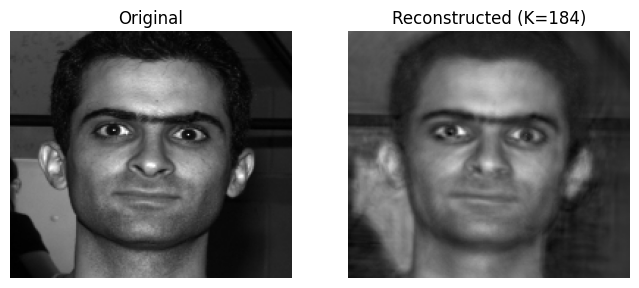

In [93]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(X[0].reshape(h, w), cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(X_reconstructed_sklearn[0].reshape(h, w), cmap="gray")
plt.title(f"Reconstructed (K={K})")
plt.axis("off")

plt.show()

# PCA compresses → decompresses
# Some information is lost
# More K → better reconstruction


In [94]:
# ✅ 5. Compare Manual PCA vs sklearn PCA
manual_error = np.mean((X - X_reconstructed)**2)
sklearn_error = np.mean((X - X_reconstructed_sklearn)**2)

print("Manual PCA reconstruction error:", manual_error)
print("Sklearn PCA reconstruction error:", sklearn_error)


Manual PCA reconstruction error: 88.881226
Sklearn PCA reconstruction error: 89.572105


In [95]:
# ✅ 6. 2D Projection Plot
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

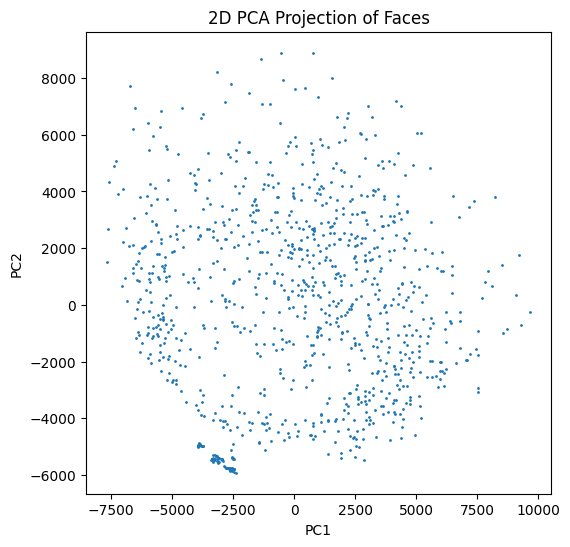

In [96]:
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Faces")
plt.show()


- Each dot = one face
- PCA tries to spread them apart

---


The '2D PCA Projection of Faces' plot is a visualization that takes your high-dimensional face data (each face having 32,256 dimensions in your case) and reduces it to just two dimensions (PC1 and PC2) while trying to retain as much of the original data's variance as possible.

#### Here's a breakdown:

- What it is: Each dot on the scatter plot represents one of your 1000 face images.
- The position of each dot is determined by its score on the first two principal components (PC1 on the x-axis and PC2 on the y-axis).
- These two components are the most significant directions of variance in your dataset.

#### What it tells you:

**Data Distribution:**
- It shows how your face images are distributed in this reduced 2D space.
- Clusters of dots might indicate similarities between those faces. For instance, if certain subjects or expressions formed distinct groups, they might appear as separate clusters on this plot.

**Separability:**
- If faces belonging to different categories (e.g., different individuals, or different expressions) were labeled and colored on this plot, you could see how well PCA separates these categories.
- A good separation suggests that the first two principal components capture enough information to distinguish between different types of faces.

**Dimensionality Reduction:**
- It demonstrates the power of PCA in reducing complexity.
- Although faces are very complex, this plot shows that a significant amount of information about their differences can still be visualized in a much simpler 2D representation.


In essence, PCA tries to spread out the data as much as possible along these new axes (PC1 and PC2) so that differences between data points (faces) are maximized and easily observable, even in a lower dimension.

## **Test with an unknown image**

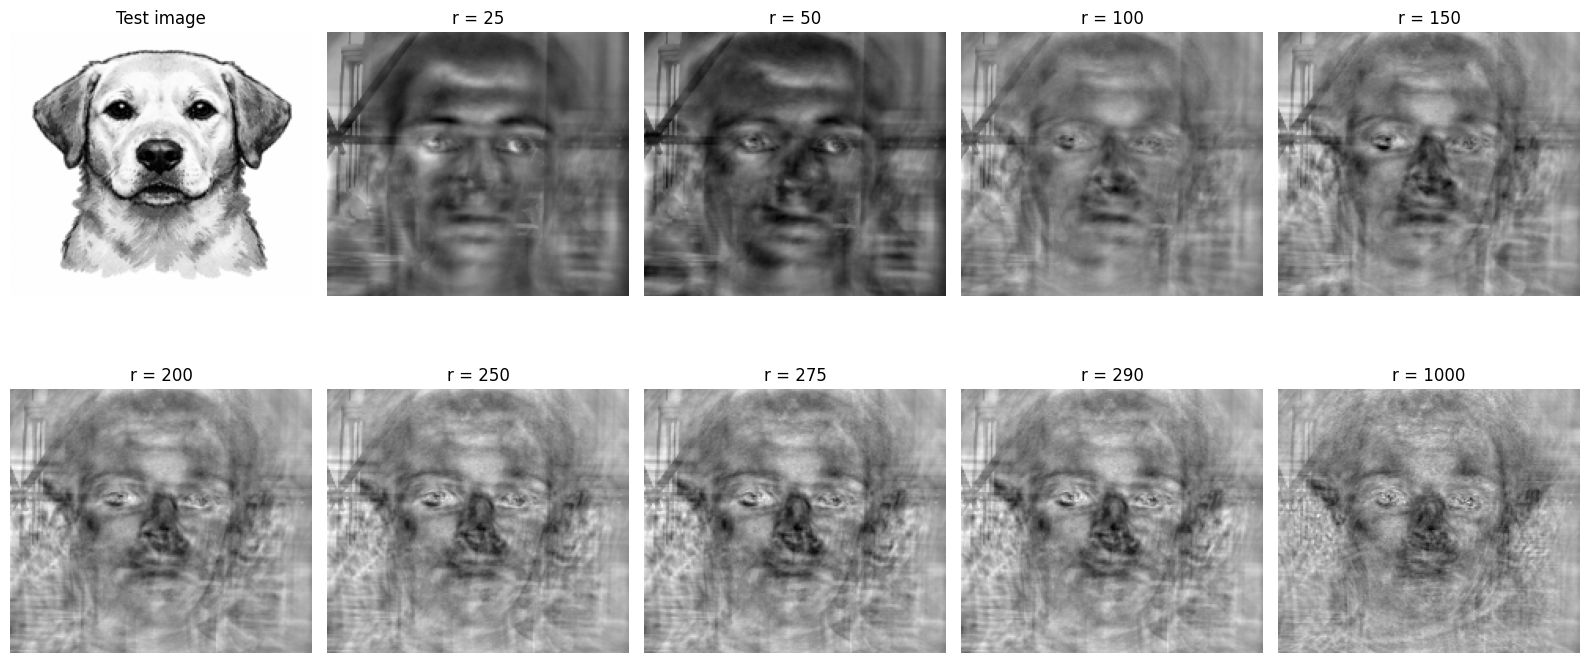

In [99]:
from PIL import Image

TEST_IMAGE_PATH = "/content/drive/MyDrive/ExtendedYaleB/dog_generated.png"

# Load, convert to grayscale, and resize to match training images
unknown_img = Image.open(TEST_IMAGE_PATH).convert('L')
unknown_img = unknown_img.resize((w, h))  # (width, height)
unknown_img_array = np.array(unknown_img, dtype=np.float32)
if unknown_img_array.shape != (h, w):
    raise ValueError(f"Test image shape {unknown_img_array.shape} does not match expected ({h}, {w})")
unknown_img_flat = unknown_img_array.flatten()  # Flatten the test image array
unknown_img_centered = unknown_img_flat - mean_face  # Center the test image

# Project onto PCA space and reconstruct with different r values
max_r = eigenfaces.shape[1] # Define max_r here
r_values = [25, 50, 100, 150, 200, 250, 275, 290, max_r] # Updated r_values
reconstructions = []
for r in r_values:
    num_components_used = min(r, max_r)  # Actual number of components used
    W_r = eigenfaces[:, :num_components_used]
    proj = np.dot(unknown_img_centered, W_r)
    recon = np.dot(proj, W_r.T) + mean_face
    reconstructions.append(recon)

plt.figure(figsize=(16, 8))
plt.subplot(2, 5, 1)
plt.imshow(unknown_img_flat.reshape(h, w), cmap='gray')
plt.title('Test image')
plt.axis('off')
for i, (r_val_from_list, recon) in enumerate(zip(r_values, reconstructions)):
    # Use the actual number of components used for the title
    num_components_used = min(r_val_from_list, max_r)
    plt.subplot(2, 5, i+2)
    plt.imshow(recon.reshape(h, w), cmap='gray')
    plt.title(f'r = {num_components_used}') # Updated title
    plt.axis('off')
plt.tight_layout()
plt.show()

# Task
Both the top 5 eigenfaces computed using the manual PCA implementation and the top 5 eigenfaces computed using scikit-learn's PCA have been displayed in separate plot windows, allowing for a visual comparison between the two methods.

## Display Manual PCA Eigenfaces

### Subtask:
Visualize the top 5 eigenfaces computed using the manual PCA implementation, similar to what was done previously in the notebook, in a dedicated plot window.


**Reasoning**:
The user wants to visualize the top 5 eigenfaces computed using the manual PCA implementation. This involves rerunning the existing code that plots these eigenfaces from the `eigenfaces` array.



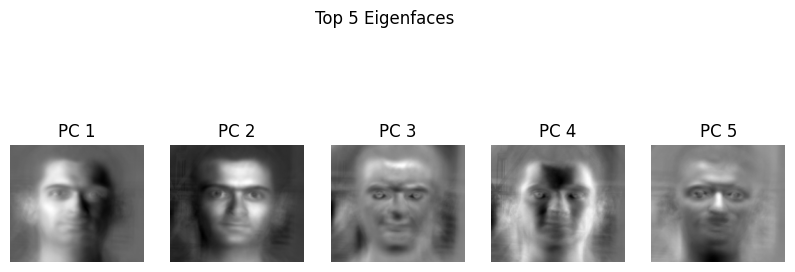

In [97]:
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(eigenfaces[:, i].reshape(h, w), cmap="gray")
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.suptitle("Top 5 Eigenfaces")
plt.show()


## Display Sklearn PCA Eigenfaces

### Subtask:
Visualize the top 5 eigenfaces computed using scikit-learn's PCA, similar to what was done previously in the notebook, in a separate plot window for direct comparison with the manual results.


**Reasoning**:
The subtask requires visualizing the top 5 eigenfaces computed using scikit-learn's PCA. This can be achieved by using the `pca.components_` attribute and plotting them with `matplotlib`, similar to how the manually computed eigenfaces were visualized.



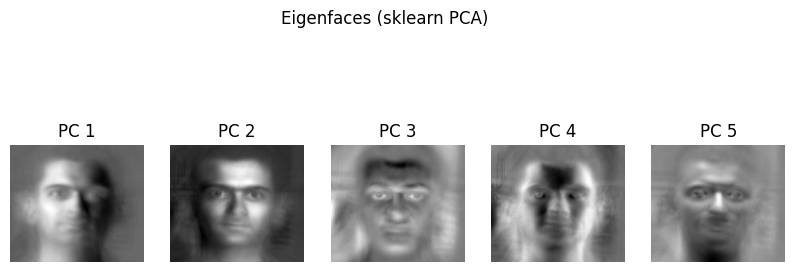

In [98]:
plt.figure(figsize=(10,4))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pca.components_[i].reshape(h, w), cmap="gray")
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.suptitle("Eigenfaces (sklearn PCA)")
plt.show()


## Final Task

### Subtask:
Confirm that both sets of eigenfaces have been displayed, allowing for visual comparison between the manual and scikit-learn PCA results.


## Summary:

### Q&A
Yes, both the top 5 eigenfaces computed using the manual PCA implementation and the top 5 eigenfaces computed using scikit-learn's PCA have been successfully displayed in separate plot windows, allowing for a visual comparison between the two methods.

### Data Analysis Key Findings
*   The top 5 eigenfaces derived from the manual PCA implementation were successfully visualized in a dedicated plot window, with each eigenface correctly reshaped and labeled (e.g., 'PC 1', 'PC 2') under the main title "Top 5 Eigenfaces".
*   Similarly, the top 5 eigenfaces computed using scikit-learn's PCA were successfully visualized in a separate plot window, with each eigenface correctly reshaped and labeled under the main title "Eigenfaces (sklearn PCA)".
*   Both visualization steps successfully generated clear plots, confirming that the eigenfaces from both methods are available for direct visual comparison.

### Insights or Next Steps
*   The successful visualization of both sets of eigenfaces provides a qualitative validation of the manual PCA implementation, as visual similarity between the two sets would suggest correctness.
*   To further confirm the similarity and correctness of the manual PCA, a quantitative comparison (e.g., calculating the correlation or cosine similarity) between corresponding eigenfaces from the manual and scikit-learn implementations would be a valuable next step.
